In [73]:
%matplotlib inline
import sys
import pickle
import scipy.io as sio
import numpy as np
import keras.backend as K
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from muon.dissolving.multitask import MultitaskDEC
from muon.subjects.storage import Storage
import pandas



import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

lcolours = ['#CAA8F5', '#D6FF79', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#B0FF92', '#D9F0FF', '#46351D']

In [2]:
# print(subjects)
# print(next(subjects.iter()).y)
# subjects.get_xy(False, 'hugh')

## Clean Labels (Hugh's annotations)

In [28]:
# import json
# from muon.utils.camera import CameraRotate

# with open('mnt/subjects/tt_split_hugh.json') as f:
#     splits = json.load(f)

# rotation=True
# splits['train'] = np.random.permutation(splits['train'])
# for k in splits:
#     print(k)
#     splits[k] = subjects.subset(splits[k]).get_xy(rotation, 'hugh')
#     print(splits[k][0].shape)

# x_test, y_test = splits['test']
# x_train, y_train = splits['train']
# x_valid, y_valid = splits['valid']
# x_train_dev, y_train_dev = splits['train_dev']

# del splits
# print(x_test.shape, x_train.shape, x_valid.shape, x_train_dev.shape)

import pickle
with open('mnt/subjects/tt_split_hugh_xy.pkl', 'rb') as f:
    splits = pickle.load(f)

x_test, y_test = splits['test']
x_train, y_train = splits['train']
x_valid, y_valid = splits['valid']
x_train_dev, y_train_dev = splits['train_dev']

print(y_train)

order = np.random.permutation(x_train.shape[0])
print(x_train.shape, y_train.shape)
x_train = x_train[order,:]
y_train = y_train[order]
print(x_train.shape, x_test.shape, x_valid.shape, x_train_dev.shape)

[0 0 0 ... 0 0 0]
[1. 1. 1. ... 1. 1. 1.]
(56688, 499) (56688,)
(56688, 499) (48612, 499) (40692, 499) (40506, 499)


In [4]:
from muon.deep_clustering.clustering import Cluster, Config
config = Config.load('mnt/clustering_models/dec/dec_no_labels/config.json')
ae_weights = 'mnt/clustering_models/dec/dec_no_labels/ae_weights.h5'
dec_weights = 'mnt/clustering_models/dec/dec_no_labels/DEC_model_final.h5'

# DEC constants from DEC paper
batch_size = 256
lr         = 0.01
momentum   = 0.9
tol        = 0.001
maxiter    = 1
#update_interval = 140 #perhaps this should be 1 for multitask learning
update_interval = 1 #perhaps this should be 1 for multitask learning
n_clusters = config.n_clusters # number of clusters to use
n_classes  = 2  # number of classes

dims = [x_train.shape[1]] + config.nodes


dec = MultitaskDEC(n_classes=n_classes, dims=dims, n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec.model.load_weights(dec_weights)
print(dec.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 499)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               250000    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 50)                500       
Total params: 1,523,010
Trainable params: 1,523,010
Non-trainable params: 0
_________________________________________________________________


Calculating metrics of the unsupervised clustering

In [65]:
from muon.dissolving.utils import get_cluster_to_label_mapping_safe, calc_f1_score, one_percent_fpr
from sklearn.metrics import homogeneity_score
from sklearn import metrics

def make_cluster_map(x):
    y_p_cluster = dec.predict_clusters(x)
    return get_cluster_to_label_mapping_safe(
        np_utils.to_categorical(y_train)[:,1], y_train_pc, n_classes, n_clusters)[0]

def calculate_metrics(x, y, c_map):
#     y = np_utils.to_categorical(y)
    y_pred_c = dec.model.predict(x)
    y_pred_c = np.argmax(y_pred_c, axis=1)
    print(y_pred_c)
#     print(np.argmax(y_pred_c, axis=1))
    y_pred = np.array(c_map)[y_pred_c]
    print(y_pred)
    print(c_map)

    f1 = f1_score(y, y_pred)
    f1c = calc_f1_score(y, y_pred_c, c_map)
    h = homogeneity_score(y, y_pred_c)
    nmi = metrics.normalized_mutual_info_score(y, y_pred_c)
    
    return f1, f1c, h, nmi
    
c_map = make_cluster_map(x_train)
metrics = calculate_metrics(x_test, y_test, c_map)
print('f1:  {:.4f}\n'
      'f1c: {:.4f}\n'
      'h:   {:.4f}\n'
      'nmi: {:.4f}\n'.format(*metrics))

0 0 0 nan
1 1608 0 0.6094527
2 1071 1 0.9850607
3 920 0 0.95
4 1665 0 0.73033035
5 1424 0 0.91292137
6 1119 0 0.9365505
7 1148 0 0.91898954
8 1881 0 0.7134503
9 1964 0 0.86558044
10 1110 0 0.64504504
11 0 0 nan
12 1340 0 0.9380597
13 689 1 0.9898403
14 1049 1 0.76835084
15 1900 0 0.9205263
16 844 0 0.9135071
17 2173 0 0.7004142
18 50 1 1.0
19 1729 0 0.70965874
20 1338 0 0.88340807
21 374 1 0.95187163
22 111 1 0.963964
23 1264 1 0.97863925
24 1484 0 0.92520213
25 519 0 0.9768786
26 1468 0 0.88419616
27 2369 0 0.8535247
28 1400 1 0.98142856
29 1440 1 0.98333335
30 191 1 0.973822
31 1188 0 0.95286196
32 1779 0 0.7453626
33 2002 0 0.9065934
34 2144 0 0.83115673
35 1211 1 0.98596203
36 1704 0 0.72124416
37 215 1 0.94418603
38 1217 1 0.9884963
39 616 1 0.96915585
40 1171 1 0.97779673
41 420 1 0.98571426
42 174 1 0.9885057
43 1470 0 0.93265307
44 385 1 0.9896104
45 1309 0 0.9060351
46 0 0 nan
47 1586 0 0.69924337
48 377 0 0.9734748
49 2078 0 0.9095284
[0. 1.] [0 1]
[0, 0, 1, 0, 0, 0, 0, 0, 0,

In [5]:
y_pred, metrics_dict, best_ite = dec.clustering(
    x_train, np_utils.to_categorical(y_train),
    (x_train_dev, np_utils.to_categorical(y_train_dev)),
    (x_valid, np_utils.to_categorical(y_valid)),
    pretrained_weights=dec_weights,
    maxiter=maxiter,
    alpha=K.variable(1.0),
    beta=K.variable(0.0),
    gamma=K.variable(0.0),
    loss_weight_decay=False,
    update_interval=update_interval)

Update interval 1
Save interval 1107.1875


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
DEBUG:muon.dissolving.multitask:
DEBUG:muon.dissolving.multitask:Building Model


0 0 0 nan
1 1608 0 0.6094527
2 1071 1 0.9850607
3 920 0 0.95
4 1665 0 0.73033035
5 1424 0 0.91292137
6 1119 0 0.9365505
7 1148 0 0.91898954
8 1881 0 0.7134503
9 1964 0 0.86558044
10 1110 0 0.64504504
11 0 0 nan
12 1340 0 0.9380597
13 689 1 0.9898403
14 1049 1 0.76835084
15 1900 0 0.9205263
16 844 0 0.9135071
17 2173 0 0.7004142
18 50 1 1.0
19 1729 0 0.70965874
20 1338 0 0.88340807
21 374 1 0.95187163
22 111 1 0.963964
23 1264 1 0.97863925
24 1484 0 0.92520213
25 519 0 0.9768786
26 1468 0 0.88419616
27 2369 0 0.8535247
28 1400 1 0.98142856
29 1440 1 0.98333335
30 191 1 0.973822
31 1188 0 0.95286196
32 1779 0 0.7453626
33 2002 0 0.9065934
34 2144 0 0.83115673
35 1211 1 0.98596203
36 1704 0 0.72124416
37 215 1 0.94418603
38 1217 1 0.9884963
39 616 1 0.96915585
40 1171 1 0.97779673
41 420 1 0.98571426
42 174 1 0.9885057
43 1470 0 0.93265307
44 385 1 0.9896104
45 1309 0 0.9060351
46 0 0 nan
47 1586 0 0.69924337
48 377 0 0.9734748
49 2078 0 0.9095284
[0. 1.] [0 1]
[0, 0, 1, 0, 0, 0, 0, 0, 0,

DEBUG:muon.dissolving.multitask:start training
DEBUG:muon.dissolving.multitask:Calculating metrics
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


------------------------------------------------
   1  F1=0.3729  F1c=0.7642  h=0.4638  nmi=0.1942
     vF1=0.3725 vF1c=0.7566 vh=0.4592 vnmi=0.1922
     loss=[0, 0, 0]
     vloss=[0.70488775, 0.70488775, 0.229319, 0.95133394]
------------------------------------------------

saving model: [inf, inf, inf] -> [0.70462 0.70462 0.22987 0.95136]
saving model:  [inf, inf, inf]  ->  [0.70462 0.70462 0.22987 0.95136]
1.0 0.0 1.0
saving model to: ./results/dec/DEC_model_0.h5
saving model to: ./results/dec/DEC_model_final.h5
0 0 0 nan
1 0 0 nan
2 0 0 nan
3 0 0 nan
4 0 0 nan
5 0 0 nan
6 0 0 nan
7 0 0 nan
8 0 0 nan
9 0 0 nan
10 0 0 nan
11 0 0 nan
12 0 0 nan
13 0 0 nan
14 113 0 0.79646015
15 0 0 nan
16 0 0 nan
17 0 0 nan
18 0 0 nan
19 0 0 nan
20 0 0 nan
21 340 0 0.87058824
22 0 0 nan
23 0 0 nan
24 0 0 nan
25 0 0 nan
26 0 0 nan
27 0 0 nan
28 23443 1 0.7776735
29 0 0 nan
30 0 0 nan
31 0 0 nan
32 0 0 nan
33 0 0 nan
34 0 0 nan
35 0 0 nan
36 0 0 nan
37 0 0 nan
38 0 0 nan
39 0 0 nan
40 0 0 nan
41 0 0 na

In [6]:
print(y_pred, metrics, best_ite)

[[0.45343456 0.5465654 ]
 [0.49008816 0.5099118 ]
 [0.4844541  0.5155459 ]
 ...
 [0.51160055 0.4883994 ]
 [0.5801369  0.41986308]
 [0.4988678  0.50113213]] {'train_h': [0.46381536050112393], 'valid_h': [0.4592355888188782], 'valid_nmi': [0.19216744022326523], 'iteration': [0], 'valid_f1c': [0.7565623260394809], 'train_f1': [0.37285116927365647], 'train_f1c': [0.7641555285540704], 'valid_f1': [0.3724589100346021], 'train_nmi': [0.19416259275657416]} 0


In [ ]:
storage = Storage('mnt/subjects/subject_data_v3.hdf5')
subjects = storage.get_subjects(storage.labeled_subjects('hugh'))

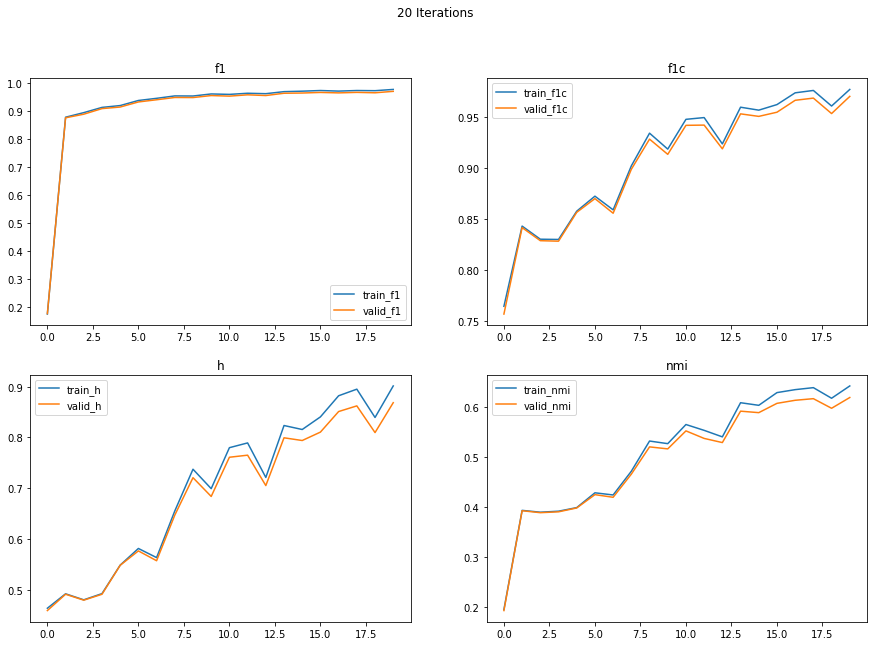

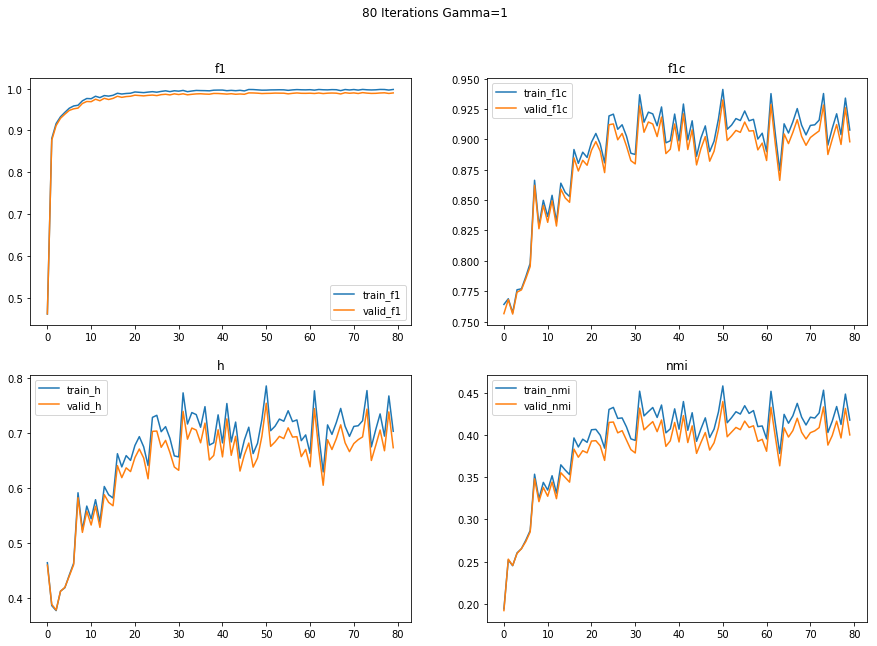

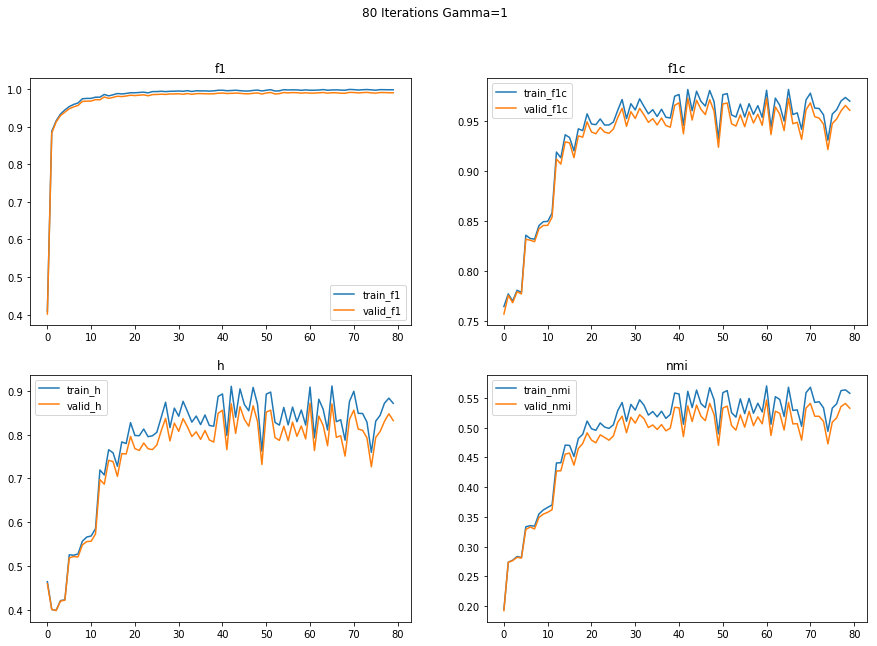

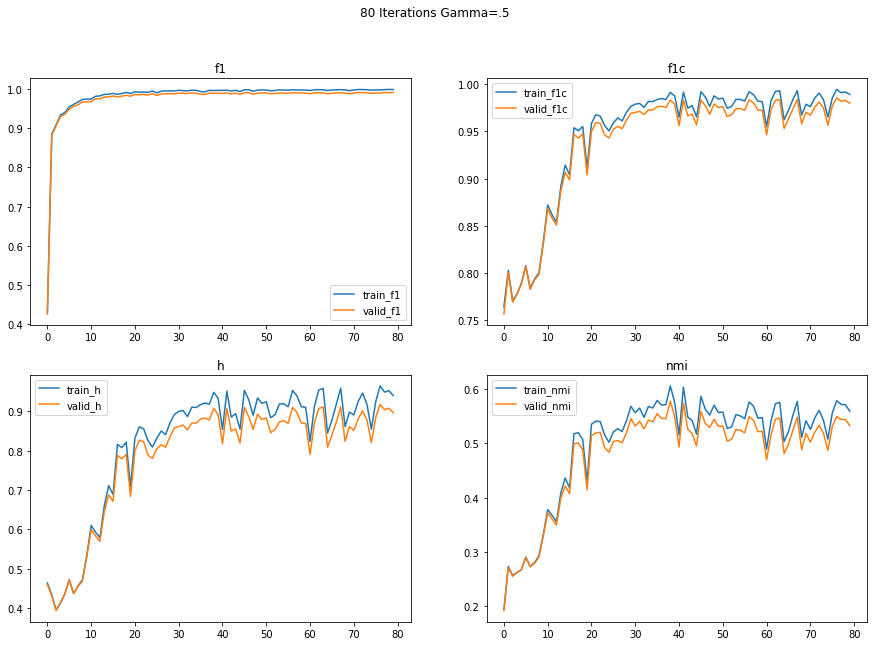

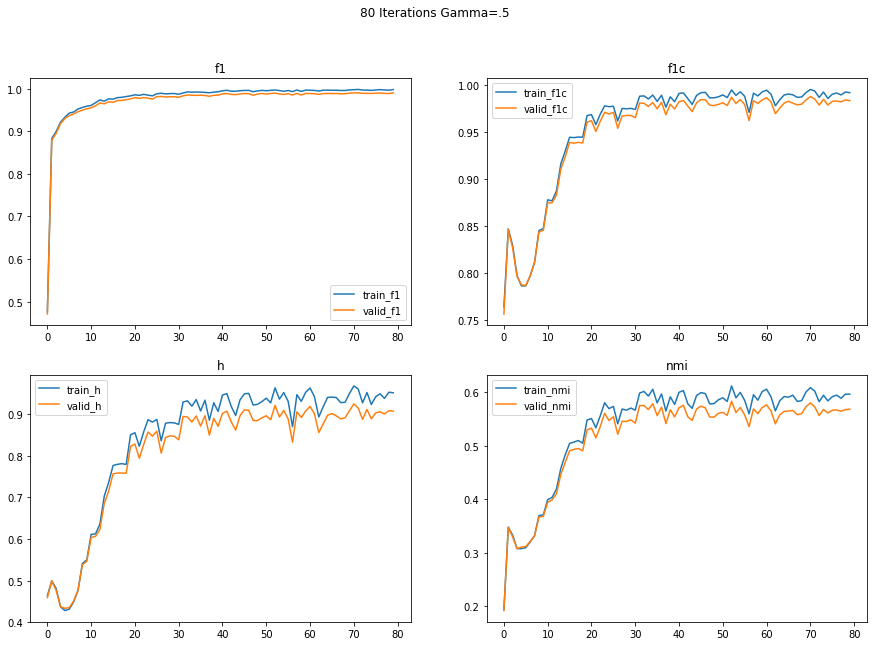

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,20 Iterations,20,0.978395,0.976840,0.901262,0.643121,0.971553,0.970043,0.868307,0.619892
1,80 Iterations Gamma=1,80,0.998163,0.907641,0.703590,0.417669,0.989910,0.898007,0.673644,0.400105
2,80 Iterations Gamma=1,80,0.997810,0.970219,0.871511,0.558021,0.989871,0.960969,0.832188,0.532859
3,80 Iterations Gamma=.5,80,0.998539,0.989160,0.940344,0.559435,0.990679,0.980005,0.896537,0.532711
4,80 Iterations Gamma=.5,80,0.998315,0.991486,0.950881,0.596920,0.990339,0.983078,0.906821,0.568545


In [105]:
import muon.dissolving.multitask
import pickle
from collections import OrderedDict
# results = pickle.load(open('mnt/clustering_models/run_multitask_1/results_final.pkl', 'rb'))

def _plot_metric(ax, data, key):
    key1 = 'train_{}'.format(key)
    key2 = 'valid_{}'.format(key)
    
    x = data['iteration']
    y1 = data[key1]
    y2 = data[key2]
    
#     print(x, y1)
    ax.plot(x, y1)
    ax.plot(x, y2)
    
    ax.legend([key1, key2])
    ax.set_title(key)
    
    return ax

def plot_metrics(data, title=None):
    fig = plt.figure(figsize=(15,10))
    for i, k in enumerate(['f1', 'f1c', 'h', 'nmi']):
        ax = fig.add_subplot(221+i)
        _plot_metric(ax, data, k)
    fig.suptitle(title)
#     pprint(results['metrics'].metrics[-1])
    
def report_run(fname, title):
    results = pickle.load(open(fname, 'rb'))
    if type(results) is dict:
        results = results['metrics']
    data = results.dump()
    plot_metrics(data, title)
    
    return data
    
def report_runs(fnames_titles):
    data = []
    for fname, title in fnames_titles:
        row = OrderedDict([('title', title)])
        item = report_run(fname, title)
        row.update([(k, item[k][-1]) for k in sorted(item)])
        row['iteration'] += 1
        data.append(row)
        plt.show()
        
    display(pandas.DataFrame(data))
        
report_runs([
#     ('mnt/clustering_models/run_multitask_1/results_final.pkl', '10 Iterations'),
#     ('mnt/clustering_models/run_multitask_2/results_final.pkl', '10 Iterations 2'),
    ('mnt/clustering_models/run_multitask_2_2/results_final.pkl', '20 Iterations'),
#     ('mnt/clustering_models/run_multitask_3/results_final.pkl', '20 Iterations Gamma=1'),
    ('mnt/clustering_models/run_multitask_4_1/results_final.pkl', '80 Iterations Gamma=1'),
#     ('mnt/clustering_models/run_multitask_5_1/results_final.pkl', '80 Iterations Gamma=.5'),
    ('mnt/clustering_models/run_multitask_4/metrics_intermediate.pkl', '80 Iterations Gamma=1'),
    ('mnt/clustering_models/run_multitask_5/metrics_intermediate.pkl', '80 Iterations Gamma=.5'),
    ('mnt/clustering_models/run_multitask_6/metrics_intermediate.pkl', '80 Iterations Gamma=.5')
#     ('mnt/clustering_models/run_multitask_7/metrics_intermediate.pkl', '80 Iterations Gamma=.5')
])
    
    

{'iteration': 9,
 'loss': [0.16755066801523913,
          0.08131755664450467,
          1.3739029614224867,
          0.08131755664450467],
 'train': {'f1': 0.9664529366504231,
           'f1c': 0.9613448866289628,
           'h': 0.8190131948525553,
           'nmi': 0.8234423254689772},
 'valid': {'f1': 0.9602849125836391,
           'f1c': 0.9552695855054499,
           'h': 0.7970895242279573,
           'nmi': 0.801554596019497},
 'vloss': [0.07953379, 0.07953379, 0.06616823, 1.365585]}


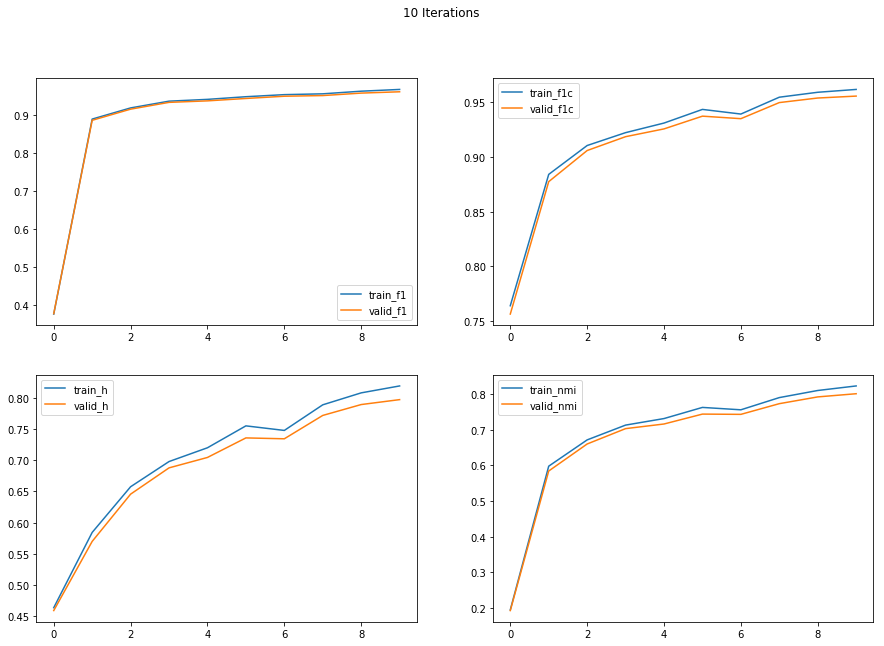

In [68]:
plot_metrics('mnt/clustering_models/run_multitask_1/results_final.pkl', title='10 Iterations')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
{'iteration': 9,
 'loss': [0.10983617957644616,
          1.8041244176629907,
          0.10983617957644616,
          0.23081744030105372],
 'train': {'f1': 0.9507748164908311,
           'f1c': 0.9523181160707488,
           'h': 0.7899354912465085,
           'nmi': 0.5475601394765482},
 'valid': {'f1': 0.9448591913666938,
           'f1c': 0.9463108767679647,
           'h': 0.7713734112972546,
           'nmi': 0.5352866495712781},
 'vloss': [0.11373362, 0.11373362, 0.10334043, 2.1431031]}


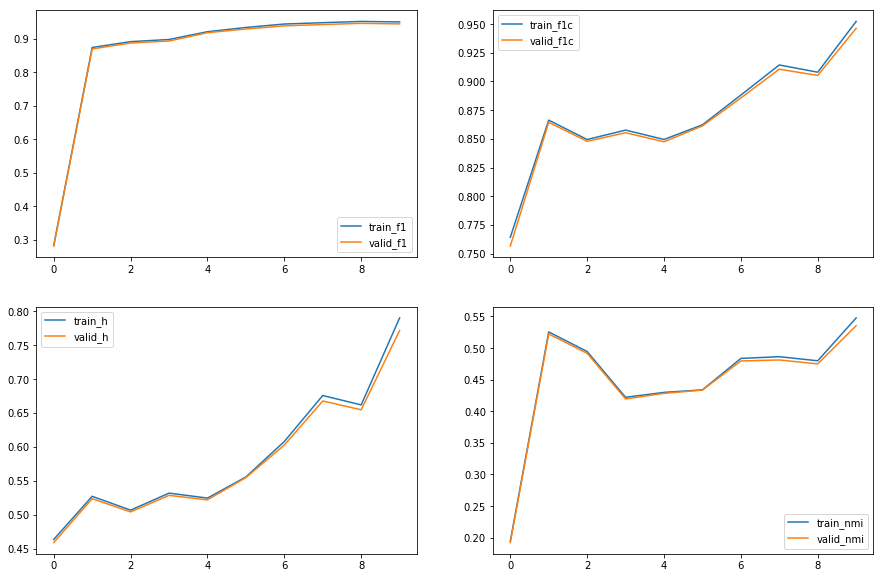

In [7]:
from pprint import pprint
results = pickle.load(open('mnt/clustering_models/run_multitask_2/results_final.pkl', 'rb'))
fig = plt.figure(figsize=(15,10))
data = results['metrics'].dump()

for i, k in enumerate(['f1', 'f1c', 'h', 'nmi']):
    ax = fig.add_subplot(221+i)
    plot_metric(ax, data, k)
# plt.show()

print(data['iteration'])

pprint(results['metrics'].metrics[-1])

In [32]:
from muon.deep_clustering.clustering import Cluster, Config
from sklearn.metrics import f1_score

config = Config.load('mnt/clustering_models/dec/dec_no_labels/config.json')
ae_weights = 'mnt/clustering_models/dec/dec_no_labels/ae_weights.h5'
dec_weights = 'mnt/clustering_models/dec/dec_no_labels/DEC_model_final.h5'

# DEC constants from DEC paper
batch_size = 256
lr         = 0.01
momentum   = 0.9
tol        = 0.001
maxiter    = 1
#update_interval = 140 #perhaps this should be 1 for multitask learning
update_interval = 1 #perhaps this should be 1 for multitask learning
n_clusters = config.n_clusters # number of clusters to use
n_classes  = 2  # number of classes

dims = [x_train.shape[1]] + config.nodes


dec = MultitaskDEC(n_classes=n_classes, dims=dims, n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)

dec.model.load_weights(dec_weights)
# dec.build_model(K.variable(1.0), K.variable(0.0), K.variable(0.0), None, None)
print(dec.model.summary())

from muon.dissolving.utils import get_cluster_to_label_mapping_safe, \
        calc_f1_score, one_percent_fpr

print(x_train.shape)
y_train_pc = dec.predict_clusters(x_train)
print(y_train_pc.shape)
c_map, _, _ = \
    get_cluster_to_label_mapping_safe(
        np_utils.to_categorical(y_train)[:,1], y_train_pc, n_classes, n_clusters)

# y_test_p = dec.model.predict(x_test)
# metrics_initial = dec._calculate_metrics(x_test, np_utils.to_categorical(y_test), y_test_p, c_map)

np_utils.to_categorical(y_train)
def calculate_metrics(x, y):
    y_pred = dec.model.predict(x)
    y_pred_cluster = dec.predict_clusters(x)
    f1 = f1_score(y, np.argmax(y_pred, axis=1))
    f1c = calc_f1_score(y, cluster_pred, c_map)
    h = homogeneity_score(y, cluster_pred)
    nmi = metrics.normalized_mutual_info_score(y, cluster_pred)
    
print(calculate_metrics(x_test, y_test))


print(metrics_initial)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 499)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               250000    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 50)                500       
Total params: 1,523,010
Trainable params: 1,523,010
Non-trainable params: 0
_________________________________________________________________


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [34]:
y_pred = dec.model.predict(x_test)
y_pred_c = dec.predict_clusters(x_test)
y_pred = np.array(c_map)[np.argmax(y_pred, axis=1)]

In [48]:
f1_score(y_test, y_pred)

0.7590266312540378

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
{'iteration': 19,
 'loss': [0.3115461013586616,
          0.04831558511515035,
          1.8704548481995864,
          0.04831558511515035],
 'train': {'f1': 0.9783952193676898,
           'f1c': 0.9768400935448991,
           'h': 0.9012616762989318,
           'nmi': 0.6431208034760443},
 'valid': {'f1': 0.9715534537116651,
           'f1c': 0.9700425951350019,
           'h': 0.8683066513105866,
           'nmi': 0.6198920919158815},
 'vloss': [0.062287945, 0.062287945, 0.09816772, 2.006752]}


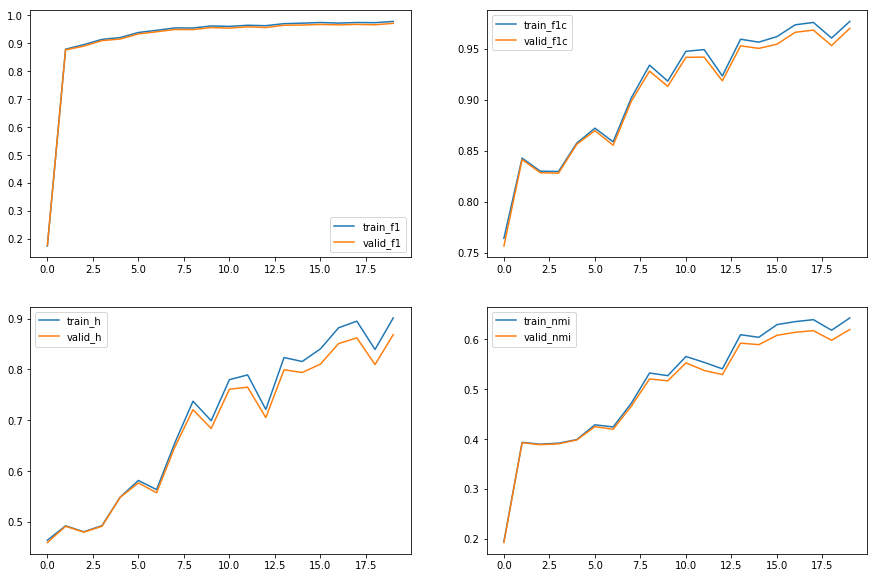

In [49]:
from pprint import pprint
results = pickle.load(open('mnt/clustering_models/run_multitask_2_2/results_final.pkl', 'rb'))
fig = plt.figure(figsize=(15,10))
data = results['metrics'].dump()

for i, k in enumerate(['f1', 'f1c', 'h', 'nmi']):
    ax = fig.add_subplot(221+i)
    plot_metric(ax, data, k)
# plt.show()

print(data['iteration'])

pprint(results['metrics'].metrics[-1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
{'iteration': 19,
 'loss': [0.04354514956053461,
          0.3532277547788257,
          0.10270220859303772,
          0.30968260505157036],
 'train': {'f1': 0.9821870111520412,
           'f1c': 0.9797524468906433,
           'h': 0.8915880207497715,
           'nmi': 0.8869455709827876},
 'valid': {'f1': 0.975668411373603,
           'f1c': 0.9730220221268279,
           'h': 0.8615087205284929,
           'nmi': 0.8573844236009207},
 'vloss': [0.3666855, 0.055918038, 0.08428897, 0.31076747]}


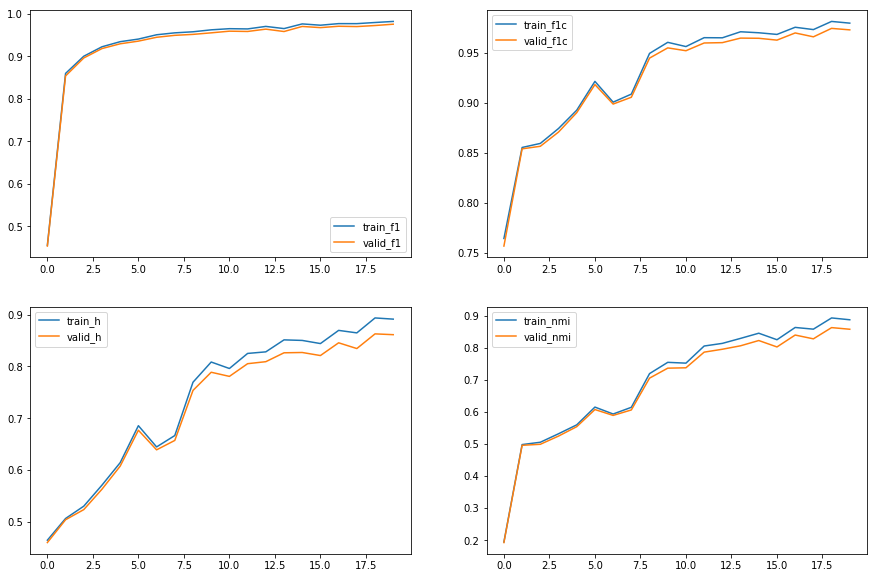

In [51]:
from pprint import pprint
results = pickle.load(open('mnt/clustering_models/run_multitask_3/results_final.pkl', 'rb'))
fig = plt.figure(figsize=(15,10))
data = results['metrics'].dump()

for i, k in enumerate(['f1', 'f1c', 'h', 'nmi']):
    ax = fig.add_subplot(221+i)
    plot_metric(ax, data, k)
# plt.show()

print(data['iteration'])

pprint(results['metrics'].metrics[-1])